# Defining the visual vocabulary

In [1]:
import cv2 as cv
import numpy as np
import os
import sys

from vocabulary import Vocabulary, open_image, draw_keypoints

In [2]:
dataset_dir = os.path.join('..', 'data')
n_words = 5

print(f'Creating vocabulary with {n_words} words')
sys.stdout.flush()
vocabulary = Vocabulary(n_words)

# Get relative paths for the images on the dataset directory
images = [os.path.join(dataset_dir, image) for image in sorted(os.listdir(dataset_dir))]

# Find keypoints for the vocabulary
vocabulary.train(images)

print(f'Vocabulary dimensions: {len(vocabulary.vocabulary.shape)}') 

Creating vocabulary with 5 words
100%|██████████| 100/100 [00:02<00:00, 34.89it/s]
Computing clusters...
Done!
Vocabulary dimensions: 2


Processing first image...


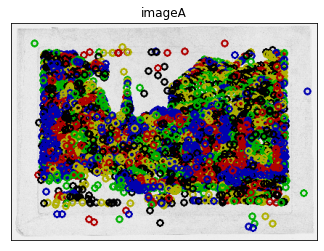

In [3]:
# Draw keypoints for the first image
query_image = images[0]

print('Processing first image...')
img_a = open_image(query_image)
if img_a is not None:
    detector = cv.BRISK_create()
    k, d = detector.detectAndCompute(img_a, None)
    words = []
    for i in range(d.shape[0]):
        words.append(vocabulary.which_word(d[i, :]))
    draw_keypoints('imageA', img_a, k, words)

# Training the Bag of Words vocabulary

In [4]:
# Perform Vector Quantization to represent the histogram of features as a vector
# Vector Quantization assigns codes from a code book to observations
from scipy.cluster.vq import vq

img_features = np.zeros((len(images), n_words), 'float32')
for i in range(len(images)):
    words, distance = vq(vocabulary.descriptor_list[i][1], vocabulary.vocabulary)
    for word in words:
        img_features[i][word] += 1

IndexError: list index out of range

In [13]:
# Perform Tf-Idf Vectorization
n_occurences = np.sum((img_features > 0) * 1, axis=0)
idf = np.array(np.log((1.0 * len(images) + 1) / (1.0 * n_occurences + 1)), 'float32')

In [14]:
# Scale the words (normalization)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(img_features)
img_features = scaler.transform(img_features)

In [21]:
# Define classes for each image
img_class = []
with open('multiclass.csv') as img_classes:
    img_class = sorted(map(lambda line: line.strip().split(','), img_classes.readlines()))

classes = [data[1] for data in img_class]
print(classes[:10])

['51', '51', '13', '70', '51', '51', '13', '25', '13', '25']


In [22]:
# Train Support Vector Classification model to discriminate vectors
from sklearn.svm import LinearSVC
svc = LinearSVC(max_iter=10000) # 10000 iterations for better odds of converging
svc.fit(img_features, np.array(classes[1:]))

c:\Users\gonca\FEUP-VCOM2\venv\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LinearSVC(max_iter=10000)

# Validating Bag of Words model